In [1]:
import sys
import os

# 현재 작업 디렉토리 확인
current_dir = os.getcwd()
print("Current directory:", current_dir)

# 프로젝트 루트 디렉토리를 Python 경로에 추가
project_root = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(project_root)

Current directory: /UHome/qtly_u/Predictive_Maintenance/image_preprocessing/image_processing


In [2]:
import os
import cv2
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
from func.func import *
import json
import ast
from skimage import feature

In [3]:
import time

json_file_path = 'result_after_processing.json'
max_retries = 5
retries = 0

while retries < max_retries:
    try:
        # 파일 읽기 시도
        with open(json_file_path, 'r') as f:
            result = json.load(f)
        break  # 성공하면 루프 종료
    except OSError as e:
        if e.errno == 116:  # Stale file handle 오류
            retries += 1
            time.sleep(1)  # 1초 대기 후 다시 시도
        else:
            print(f"Failed to open file: {e}")
            break  # 다른 오류는 루프 종료

In [4]:
len(result)

11737

In [5]:
result[0].keys()

dict_keys(['bbox_id', 'category_id', 'center', 'image_id', 'keypoints', 'scale', 'score'])

In [6]:
# center = []
image_id = []
score = []
bbox_id = []

for item in result:
    # center.append(item['center'])
    image_id.append(item['image_id'])
    score.append(item['score'])
    bbox_id.append(item['bbox_id'])

# result_df = pd.DataFrame({'image_id':image_id,'center':center, 'score':score})
result_df = pd.DataFrame({'image_id':image_id,'bbox_id':bbox_id, 'score':score})
result_df

,image_id,bbox_id,score
0,136,1,0.615619
1,136,0,0.548477
2,397,0,0.422394
3,443,0,0.445117
4,443,2,0.430084
...,...,...,...
11732,581674,3,0.432098
11733,581683,0,0.601338
11734,581683,1,0.467200
11735,581880,0,0.273316


### result_df에 bbox area 붙이기

** bbox_id로 가져오려고 모델 inference 과정 중 생성되는 변수에 대해 가져옴(rec_result.json)

In [7]:
# JSON 파일 읽기
with open('/UHome/qtly_u/3D_Bio_Object_Detection/ViTPose/work_dirs/rec_result.json', 'r') as anno:
    json_data = json.load(anno)

In [9]:
def get_bbox_by_image_file_and_bbox_id(json_data, target_image_file, target_bbox_id):
    for item in json_data:
        if "bbox_id" in item and "image_file" in item and item["image_file"] == target_image_file and item["bbox_id"] == target_bbox_id:
            return item.get("bbox")
    return None

target_bbox_id=0
target_image_file = "data/coco/val2017/000000000136.jpg"
bbox_result = get_bbox_by_image_file_and_bbox_id(json_data, target_image_file, target_bbox_id)

In [10]:
bbox_result

In [78]:
file_path = "data/coco/val2017/"
result_df['image_file'] = file_path + result_df['image_id'].astype(str).apply(lambda x: x.zfill(12)) + '.jpg'

In [79]:
result_df.columns

Index(['image_id', 'bbox_id', 'score', 'image_file', 'bbox'], dtype='object')

In [80]:
result_df['bbox'] = result_df.apply(lambda row: get_bbox_by_image_file_and_bbox_id(json_data, row['image_file'], row['bbox_id']), axis=1)

In [82]:
result_df['bbox'].isna()==False

,image_id,bbox_id,score,image_file,bbox


In [81]:
annotation_df

,image_id,id,bbox,width,height,bbox_size
0,136,500146,"[0.84, 114.71, 53.54, 257.7]",53.54,257.70,13797.2580
1,136,502933,"[0, 61.35, 68.92, 312.65]",68.92,312.65,21547.8380
2,397,2151765,"[3.74, 0, 225.66, 205.33]",225.66,205.33,46334.7678
3,443,184971,"[117.57, 1.08, 519.91, 472.45]",519.91,472.45,245631.4795
4,443,224310,"[488.63, 2.16, 151.37, 303.1]",151.37,303.10,45880.2470
...,...,...,...,...,...,...
15514,581674,1746490,"[133.43, 164.25, 52.24, 117.46]",52.24,117.46,6136.1104
15515,581683,445516,"[380.57, 428.83, 47.39, 124.04]",47.39,124.04,5878.2556
15516,581683,1222053,"[359.5, 384.93, 45, 91.37]",45.00,91.37,4111.6500
15517,581880,456253,"[3.74, 20.95, 216.26, 203.54]",216.26,203.54,44017.5604


In [62]:
df = pd.concat([result_df, annotation_df], axis=1)

In [63]:
df.columns

Index(['image_id', 'bbox_id', 'score', 'image_id', 'id', 'bbox', 'width',
       'height', 'bbox_size'],
      dtype='object')

In [43]:
# 중복된 열 이름 확인
duplicated_columns = df.columns[df.columns.duplicated()].tolist()

# 이름이 같은 열 중 첫 번째 열만 남기고 나머지는 제거
df = df.loc[:, ~df.columns.duplicated()]

In [64]:
df

,image_id,bbox_id,score,image_id,id,bbox,width,height,bbox_size
0,136.0,0.0,0.548477,136,500146,"[0.84, 114.71, 53.54, 257.7]",53.54,257.70,13797.2580
1,136.0,1.0,0.615619,136,502933,"[0, 61.35, 68.92, 312.65]",68.92,312.65,21547.8380
2,397.0,0.0,0.422394,397,2151765,"[3.74, 0, 225.66, 205.33]",225.66,205.33,46334.7678
3,443.0,1.0,0.385667,443,184971,"[117.57, 1.08, 519.91, 472.45]",519.91,472.45,245631.4795
4,443.0,2.0,0.430084,443,224310,"[488.63, 2.16, 151.37, 303.1]",151.37,303.10,45880.2470
...,...,...,...,...,...,...,...,...,...
15514,NaN,NaN,NaN,581674,1746490,"[133.43, 164.25, 52.24, 117.46]",52.24,117.46,6136.1104
15515,NaN,NaN,NaN,581683,445516,"[380.57, 428.83, 47.39, 124.04]",47.39,124.04,5878.2556
15516,NaN,NaN,NaN,581683,1222053,"[359.5, 384.93, 45, 91.37]",45.00,91.37,4111.6500
15517,NaN,NaN,NaN,581880,456253,"[3.74, 20.95, 216.26, 203.54]",216.26,203.54,44017.5604


## metric 계산 적용

In [44]:
file_path = '/UHome/qtly_u/Predictive_Maintenance/image_preprocessing/output_folder/'
df['image_file'] = file_path + df['image_id'].astype(str).apply(lambda x: x.zfill(12)) + '.jpg'

In [53]:
df['image_file'].head().str[50:]

0    essing/output_folder/0000000136.0.jpg
1    essing/output_folder/0000000136.0.jpg
2    essing/output_folder/0000000397.0.jpg
3    essing/output_folder/0000000443.0.jpg
4    essing/output_folder/0000000443.0.jpg
Name: image_file, dtype: object

[ WARN:0@1026.674] global loadsave.cpp:248 findDecoder imread_('/UHome/qtly_u/Predictive_Maintenance/image_preprocessing/output_folder/0000000136.0.jpg'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

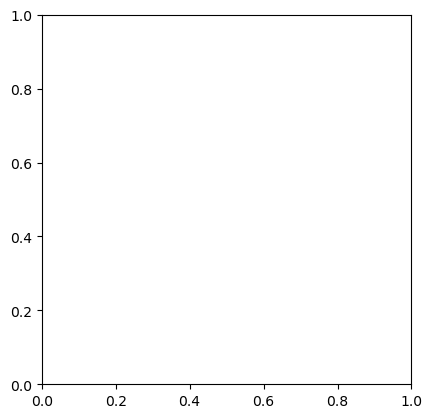

In [47]:
entropy = []
laplacian = []
brightness = []
B_sd = []
c_moment = []
contra = []
img_size = []
edge_intensity = []
edge_num = []
sift = []
psnr = []
centroid_l = []

for i in range(len(df)):
    bbox = df.loc[i,'bbox']
    
    # bbox 정보에서 x, y, w, h 추출
    x, y, w, h = map(int, bbox)

    # 이미지 로드
    image_file_path = df.loc[i,'image_file']
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image)

    height, width= image.shape
    img_size_value = width * height

    # 이미지를 bbox에 맞게 자르기
    cropped_image = image[y:y+h, x:x+w]
    entropy_value = calculate_image_entropy_(cropped_image)
    laplacian_value = calculate_laplacian_variance_(cropped_image)
    brightness_value = np.mean(cropped_image)
    sd_value = np.std(cropped_image)
    c_moment_value = moment(cropped_image)
    contrast_value = calculate_contrast(cropped_image)
    edge_num_value, edge_value = edge(cropped_image)
    SIFT_count_value = SIFT_count(cropped_image)
    psnr_value = calculate_psnr(cropped_image)
    cx, cy = c_moment_value
    centroid_l_value = centroid_degree(w, h, cx, cy)

    entropy.append(entropy_value)
    laplacian.append(laplacian_value)
    brightness.append(brightness_value)
    B_sd.append(sd_value)
    c_moment.append(c_moment_value)
    contra.append(contrast_value)
    img_size.append(img_size_value)
    edge_intensity.append(edge_value)
    edge_num.append(edge_num_value)
    sift.append(SIFT_count_value)
    psnr.append(psnr_value)
    centroid_l.append(centroid_l_value)

In [73]:
# RGB
red = []
green = []
blue = []
color_var = []

# Not Grayscale
for i in range(len(df)):
    bbox = df.loc[i,'bbox']
    
    # bbox 정보에서 x, y, w, h 추출
    x, y, w, h = map(int, bbox)

    # 이미지 로드
    image_file_path = df.loc[i,'image_file']
    image = cv2.imread(image_file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 이미지를 bbox에 맞게 자르기
    cropped_image = image[y:y+h, x:x+w]
    
    # 이미지 배열에서 각 채널의 값 가져오기
    red_channel = cropped_image[:, :, 0]
    green_channel = cropped_image[:, :, 1]
    blue_channel = cropped_image[:, :, 2]

    # 각 채널별 평균과 분산 계산
    red_mean, red_variance = np.mean(red_channel), np.var(red_channel)
    green_mean, green_variance = np.mean(green_channel), np.var(green_channel)
    blue_mean, blue_variance = np.mean(blue_channel), np.var(blue_channel)
    variance = np.mean([red_variance,green_variance,blue_variance])

    red.append(red_mean)
    green.append(green_mean)
    blue.append(blue_mean)
    color_var.append(variance)

In [74]:
# HSV
saturation = []

# Not Grayscale
for i in range(len(df)):
    bbox = df.loc[i,'bbox']
    
    # bbox 정보에서 x, y, w, h 추출
    x, y, w, h = map(int, bbox)

    # 이미지 로드
    image_file_path = df.loc[i,'image_file']
    image = cv2.imread(image_file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 이미지를 bbox에 맞게 자르기
    cropped_image = image[y:y+h, x:x+w]

    saturation_value = np.mean(cropped_image[:, :, 1])

    saturation.append(saturation_value)

In [75]:
df['entropy'] = entropy
df['laplacian'] = laplacian
df['brightness'] = brightness
df['B_sd'] = B_sd
df['red'] = red
df['blue'] = blue
df['green'] = green
df['color_var'] = color_var
df['c_moment'] = c_moment
df['contrast'] = contra
df['img_size'] = img_size
df['edge_intensity'] = edge_intensity
df['edge_num'] = edge_num
df['saturation'] = saturation
df['sift'] = sift
df['psnr'] = psnr
df['centroid_l'] = centroid_l

In [76]:
# 새로운 열 생성
df[['c_moment_x', 'c_moment_y']] = pd.DataFrame(df['c_moment'].tolist(), index=df.index)

# 기존 열 삭제
# df = df.drop('c_moment', axis=1)

In [77]:
df['bbox_prop'] = df['bbox_size']/df['img_size'].values

In [78]:
df = df[['image_file'] + [col for col in df.columns if col != 'image_file']]

In [79]:
tmp = df.sort_values(by='score', ascending=False).reset_index(drop=True)

In [80]:
tmp.columns

Index(['image_file', 'image_id', 'center', 'score', 'id', 'bbox', 'width',
       'height', 'bbox_size', 'x', 'y', 'scale', 'entropy', 'laplacian',
       'brightness', 'B_sd', 'red', 'blue', 'green', 'color_var', 'c_moment',
       'contrast', 'img_size', 'edge_intensity', 'edge_num', 'saturation',
       'sift', 'psnr', 'centroid_l', 'c_moment_x', 'c_moment_y', 'bbox_prop'],
      dtype='object')

In [81]:
# tmp.to_csv("refine_merged_df.csv", index=False)

-----------

### Haralick feature

In [82]:
import mahotas

image_file = []
haralick = []
for i in range(len(df)):
    bbox = df.loc[i,'bbox']
    
    # bbox 정보에서 x, y, w, h 추출
    x, y, w, h = map(int, bbox)

    # 이미지 로드
    image_file_path = df.loc[i,'image_file']
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)

    # 이미지를 bbox에 맞게 자르기
    cropped_image = image[y:y+h, x:x+w]

    # Haralick 텍스처 특징 계산
    features = mahotas.features.haralick(cropped_image).mean(axis=0)
    haralick.append(features)
    image_file.append(image_file_path)

In [83]:
# 각 Haralick 특징을 열로 하는 데이터프레임 생성
haralick_df = pd.DataFrame(haralick, columns=[
    'ASM', 'Contrast', 'Correlation', 'Variance', 'IDM', 'Sum_Average',
    'Sum_Variance', 'Sum_Entropy', 'Entropy', 'Difference_Variance',
    'Difference_Entropy', 'IMC1', 'IMC2'
])

# 데이터프레임 출력
print(haralick_df)

            ASM     Contrast  Correlation     Variance       IDM  Sum_Average  \
0      0.000525   479.145699     0.905425  2533.215676  0.175300   151.482913   
1      0.000525   479.145699     0.905425  2533.215676  0.175300   151.482913   
2      0.000139   275.761383     0.966013  4056.610217  0.099312   219.477707   
3      0.000284   179.811717     0.974653  3547.682077  0.194467   270.149254   
4      0.000186   412.177709     0.792317   992.316768  0.099870   202.392085   
...         ...          ...          ...          ...       ...          ...   
11732  0.000162  1025.953989     0.886839  4534.208606  0.129250   280.357273   
11733  0.000245   663.141496     0.910784  3728.185183  0.089435   200.182454   
11734  0.000395   663.474420     0.940958  5617.290990  0.122372   169.130335   
11735  0.000827    98.610837     0.983090  2915.985551  0.288825   207.817693   
11736  0.000566   174.212777     0.883537   750.163444  0.148828   199.804593   

       Sum_Variance  Sum_En

In [84]:
tmp = pd.concat([df, haralick_df], axis=1)
tmp = tmp.sort_values(by='score', ascending=False).reset_index(drop=True)

In [85]:
numeric_cols = tmp.select_dtypes(include=['float64', 'int64']).columns
numeric_df = tmp[numeric_cols]
numeric_df

,image_id,score,id,width,height,bbox_size,x,y,entropy,laplacian,...,Variance,IDM,Sum_Average,Sum_Variance,Sum_Entropy,Entropy,Difference_Variance,Difference_Entropy,IMC1,IMC2
0,493278,0.944694,2161847,274.59,607.46,166802.4414,277.00,15.80,7.653786,2685.354507,...,4466.448126,0.142650,295.464982,17275.142559,8.631644,13.249844,0.000182,4.979119,-0.268948,0.991563
1,380516,0.936719,454982,239.39,255.95,61271.8705,88.08,58.72,7.851981,6693.019774,...,3754.576578,0.101740,262.613177,13797.557900,8.782549,14.000776,0.000111,5.685149,-0.216912,0.982681
2,478115,0.934750,2167424,154.12,117.22,18065.9464,393.70,362.09,7.339297,6769.783152,...,2189.030168,0.062624,149.728014,7850.714888,8.224662,13.243863,0.000081,5.784825,-0.193211,0.969909
3,530901,0.934004,447609,486.49,346.39,168515.2711,6.72,71.97,7.580059,1065.078473,...,3937.742245,0.199688,155.121625,15499.945718,8.564878,12.776815,0.000249,4.563351,-0.314597,0.995513
4,419689,0.930691,448796,258.75,503.63,130314.2625,11.96,113.42,7.346811,964.792609,...,6438.488806,0.169846,257.007672,25419.859079,8.326502,12.645260,0.000195,4.831324,-0.278818,0.991085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11732,182710,0.000000,1204482,147.11,149.26,21957.6386,492.89,325.47,7.840692,2310.263113,...,6399.956708,0.180200,275.502559,24942.416806,8.803489,12.896015,0.000174,5.146087,-0.355463,0.998037
11733,176038,0.000000,1709854,43.92,39.24,1723.4208,0.00,34.65,7.039105,1299.938068,...,2464.119195,0.141726,162.289704,9327.656907,7.796325,10.593825,0.000234,4.835030,-0.489601,0.999463
11734,1536,0.000000,1228212,87.68,97.86,8580.3648,0.00,11.29,7.623972,1919.905314,...,3238.401756,0.117067,251.495261,12420.871248,8.556692,12.534473,0.000180,4.950269,-0.355359,0.997737
11735,300021,0.000000,1732741,152.78,113.81,17387.8918,335.83,2.35,7.319908,1298.571849,...,2720.670323,0.119177,139.030328,10611.835456,8.241743,12.416054,0.000186,4.721405,-0.301361,0.993796


In [86]:
tmp2 = numeric_df.drop(columns=['x','y'])
tmp2

,image_id,score,id,width,height,bbox_size,entropy,laplacian,brightness,B_sd,...,Variance,IDM,Sum_Average,Sum_Variance,Sum_Entropy,Entropy,Difference_Variance,Difference_Entropy,IMC1,IMC2
0,493278,0.944694,2161847,274.59,607.46,166802.4414,7.653786,2685.354507,147.669982,66.834492,...,4466.448126,0.142650,295.464982,17275.142559,8.631644,13.249844,0.000182,4.979119,-0.268948,0.991563
1,380516,0.936719,454982,239.39,255.95,61271.8705,7.851981,6693.019774,131.236000,61.231409,...,3754.576578,0.101740,262.613177,13797.557900,8.782549,14.000776,0.000111,5.685149,-0.216912,0.982681
2,478115,0.934750,2167424,154.12,117.22,18065.9464,7.339297,6769.783152,74.989344,47.037883,...,2189.030168,0.062624,149.728014,7850.714888,8.224662,13.243863,0.000081,5.784825,-0.193211,0.969909
3,530901,0.934004,447609,486.49,346.39,168515.2711,7.580059,1065.078473,77.515670,62.730747,...,3937.742245,0.199688,155.121625,15499.945718,8.564878,12.776815,0.000249,4.563351,-0.314597,0.995513
4,419689,0.930691,448796,258.75,503.63,130314.2625,7.346811,964.792609,128.503722,80.222347,...,6438.488806,0.169846,257.007672,25419.859079,8.326502,12.645260,0.000195,4.831324,-0.278818,0.991085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11732,182710,0.000000,1204482,147.11,149.26,21957.6386,7.840692,2310.263113,137.562845,79.938201,...,6399.956708,0.180200,275.502559,24942.416806,8.803489,12.896015,0.000174,5.146087,-0.355463,0.998037
11733,176038,0.000000,1709854,43.92,39.24,1723.4208,7.039105,1299.938068,81.445438,49.929349,...,2464.119195,0.141726,162.289704,9327.656907,7.796325,10.593825,0.000234,4.835030,-0.489601,0.999463
11734,1536,0.000000,1228212,87.68,97.86,8580.3648,7.623972,1919.905314,125.741083,56.930346,...,3238.401756,0.117067,251.495261,12420.871248,8.556692,12.534473,0.000180,4.950269,-0.355359,0.997737
11735,300021,0.000000,1732741,152.78,113.81,17387.8918,7.319908,1298.571849,69.983407,52.547388,...,2720.670323,0.119177,139.030328,10611.835456,8.241743,12.416054,0.000186,4.721405,-0.301361,0.993796


In [87]:
tmp2

,image_id,score,id,width,height,bbox_size,entropy,laplacian,brightness,B_sd,...,Variance,IDM,Sum_Average,Sum_Variance,Sum_Entropy,Entropy,Difference_Variance,Difference_Entropy,IMC1,IMC2
0,493278,0.944694,2161847,274.59,607.46,166802.4414,7.653786,2685.354507,147.669982,66.834492,...,4466.448126,0.142650,295.464982,17275.142559,8.631644,13.249844,0.000182,4.979119,-0.268948,0.991563
1,380516,0.936719,454982,239.39,255.95,61271.8705,7.851981,6693.019774,131.236000,61.231409,...,3754.576578,0.101740,262.613177,13797.557900,8.782549,14.000776,0.000111,5.685149,-0.216912,0.982681
2,478115,0.934750,2167424,154.12,117.22,18065.9464,7.339297,6769.783152,74.989344,47.037883,...,2189.030168,0.062624,149.728014,7850.714888,8.224662,13.243863,0.000081,5.784825,-0.193211,0.969909
3,530901,0.934004,447609,486.49,346.39,168515.2711,7.580059,1065.078473,77.515670,62.730747,...,3937.742245,0.199688,155.121625,15499.945718,8.564878,12.776815,0.000249,4.563351,-0.314597,0.995513
4,419689,0.930691,448796,258.75,503.63,130314.2625,7.346811,964.792609,128.503722,80.222347,...,6438.488806,0.169846,257.007672,25419.859079,8.326502,12.645260,0.000195,4.831324,-0.278818,0.991085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11732,182710,0.000000,1204482,147.11,149.26,21957.6386,7.840692,2310.263113,137.562845,79.938201,...,6399.956708,0.180200,275.502559,24942.416806,8.803489,12.896015,0.000174,5.146087,-0.355463,0.998037
11733,176038,0.000000,1709854,43.92,39.24,1723.4208,7.039105,1299.938068,81.445438,49.929349,...,2464.119195,0.141726,162.289704,9327.656907,7.796325,10.593825,0.000234,4.835030,-0.489601,0.999463
11734,1536,0.000000,1228212,87.68,97.86,8580.3648,7.623972,1919.905314,125.741083,56.930346,...,3238.401756,0.117067,251.495261,12420.871248,8.556692,12.534473,0.000180,4.950269,-0.355359,0.997737
11735,300021,0.000000,1732741,152.78,113.81,17387.8918,7.319908,1298.571849,69.983407,52.547388,...,2720.670323,0.119177,139.030328,10611.835456,8.241743,12.416054,0.000186,4.721405,-0.301361,0.993796


In [88]:
tmp2.to_csv("processed_image.csv", index=False)